# Find titers by strain passage history

I need to find the number of titer measurements for which:

 * both test and reference strains are unpassaged
 * only the test strain is unpassaged
 * the test strain is passaged
 
Given the above, here is where the data live:
 
 * titers: `dist/fauna/data/h3n2_who_hi_cell_titers.tsv`
 * list of (potentially or definitely) passaged strains: `outliers/non_reference_passaged_strains.txt`

In [43]:
import pandas as pd
%matplotlib inline

In [25]:
# Open list of passaged strains.
with open("../outliers/non_reference_passaged_strains.txt", "r") as fh:
    passaged_strains = set([line.rstrip().split("|")[0] for line in fh])

In [26]:
len(passaged_strains)

43966

In [11]:
titers = pd.read_table(
    "../dist/fauna/data/h3n2_who_hi_cell_titers.tsv",
    header=None,
    index_col=False,
    names=["test", "reference", "serum", "source", "titer", "assay"]
)

In [27]:
list(passaged_strains)[:10]

['A/Latvia/1-34462p/2012',
 'A/Georgia/4269/2015',
 'A/Thailand/CU-H3680/2014',
 'A/Brisbane/190/2017-egg',
 'A/Torino/14/2008',
 'A/Guangdong/SZ1090/1999',
 'A/Finland/736/2017',
 'A/Quebec/RV0899/2009',
 'A/Nepal/1302A/2013',
 'A/NewYork/801/1993']

In [13]:
def get_passage_status(record):
    test_unpassaged = record["test"] not in passaged_strains
    ref_unpassaged = record["reference"] not in passaged_strains
    
    if test_unpassaged and ref_unpassaged:
        return "unpassaged"
    elif test_unpassaged:
        return "test_unpassaged"
    elif ref_unpassaged:
        return "ref_unpassaged"
    else:
        return "passaged"

In [28]:
titers["passage_status"] = titers.apply(get_passage_status, axis=1)

In [29]:
titers.shape

(115951, 7)

In [30]:
titers["passage_status"].value_counts()

unpassaged         38778
ref_unpassaged     29467
passaged           27217
test_unpassaged    20489
Name: passage_status, dtype: int64

In [35]:
distinct_unpassaged_viruses = titers[titers["passage_status"] == "unpassaged"].loc[:, ["test", "reference", "serum"]].drop_duplicates()

In [46]:
distinct_unpassaged_viruses["test"].apply(lambda virus: int(virus.split("/")[-1].replace("-egg", ""))).value_counts()

2017    10167
2016     5869
2014     3922
2012     3178
2013     2820
2018     1719
2015     1673
2011      330
2005       52
2007       34
2009       27
2008       23
2003        7
5060        4
2010        4
2006        4
3120        3
2002        1
Name: test, dtype: int64

In [47]:
distinct_passaged_viruses = titers[titers["passage_status"] != "unpassaged"].loc[:, ["test", "reference", "serum"]].drop_duplicates()

In [58]:
passaged_measurements_per_year = distinct_passaged_viruses["test"].apply(
    lambda virus: int(virus.split("/")[-1].replace("-egg", ""))
).value_counts().reset_index()

In [59]:
passaged_measurements_per_year

,index,test
0,2012,11902
1,2014,8833
2,2017,6904
3,2013,5495
4,2016,4896
5,2015,3786
6,2011,3537
7,2018,1717
8,2004,1203
9,2005,620


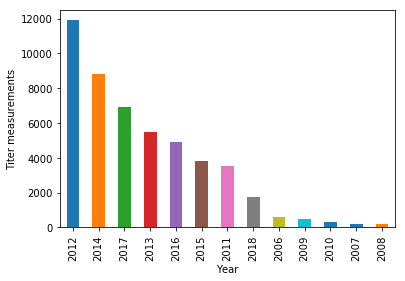

In [64]:
ax = passaged_measurements_per_year[(passaged_measurements_per_year["index"] > 2005) & (passaged_measurements_per_year["index"] < 2019)].plot(
    x="index",
    y="test",
    kind="bar",
    legend=False
)
ax.set_xlabel("Year")
ax.set_ylabel("Titer measurements")